Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Aiman Lameesa"
ID = "st122876"

---

# Lab 10: Convolutional Neural Networks

Today we'll experiment with CNNs. We'll start with a hand-coded CNN structure based on numpy, then we'll move to PyTorch.

## CNN Explainer

Before doing this tutorial, take a look at [the CNN Explainer](https://poloclub.github.io/cnn-explainer/).
It gives beautiful illustrations of what's happening in a CNN at every level.

## Connect to google drive for colab users

For the students who use google colab for run the system. It is better to upload your dataset or weight, model into your drive. The colab system will be reset everytime when the system has log off.

Ok, let's mount the drive

In [1]:
# for colab only
from google.colab import drive
drive.mount('/content/gdrive')

# Your root path in gdrive
root_path = 'gdrive/My Drive/'

Mounted at /content/gdrive


Let's create folder

In [2]:
# for create the folder
import os

lab_path =  root_path + 'lab09/'
if not os.path.exists(lab_path):
  print("No folder ", lab_path, 'exist. Create the folder')
  os.mkdir(lab_path)
  print("Create directory finished")
else:
  print(lab_path, 'existed, do nothing')

gdrive/My Drive/lab09/ existed, do nothing


For the person who want to use google drive as your memory you can check [PyDrive](https://pypi.org/project/PyDrive/). In this class, we do not talk about it.

## Hand-coded CNN

This example is based on [Ahmed Gad's tutorial](https://www.kdnuggets.com/2018/04/building-convolutional-neural-network-numpy-scratch.html).

We will implement a very simple CNN in numpy. The model will have
just three layers, a convolutional layer (conv for short), a ReLU activation layer, and max pooling. The major steps involved are as follows.
1. Reading the input image.
2. Preparing filters.
3. Conv layer: Convolving each filter with the input image.
4. ReLU layer: Applying ReLU activation function on the feature maps (output of conv layer).
5. Max Pooling layer: Applying the pooling operation on the output of ReLU layer.
6. Stacking the conv, ReLU, and max pooling layers.

### Reading an input image
 
The following code reads an existing image using the SciKit-Image Python library and converts it into grayscale. You may need to `pip install scikit-image`.

Image dimensions: (300, 451, 3)


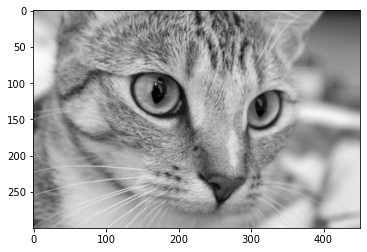

In [ ]:
import skimage.data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Read image
img = skimage.data.chelsea()
print('Image dimensions:', img.shape)

# Convert to grayscale
img = skimage.color.rgb2gray(img)
plt.imshow(img, cmap='gray')
plt.show()

### Create some filters for the conv layer

Recall that a conv layer uses some number of convolution (actually cross correlation) filters, usually matching the number
of channels in the input (1 in our case since the image is grayscale). Each kernel gives us one feature map (channel) in the
result.

Let's make two 3$\times$3 filters, using the horizontal and vertical Sobel edge filters:

In [ ]:
l1_filters = np.zeros((2,3,3))
l1_filters[0, :, :] = np.array([[[-1, 0, 1], 
                                 [-2, 0, 2], 
                                 [-1, 0, 1]]])
l1_filters[1, :, :] = np.array([[[-1, -2, -1], 
                                 [ 0,  0,  0], 
                                 [ 1,  2,  1]]])

### Conv layer feedforward step
 
Let's convolve the input image with our filters.

In [ ]:
# Perform stride 1 cross correlation of an image and a filter. We output the valid region only
# (no padding).
def convolve(img, conv_filter):
    stride = 1
    padding = 0
    filter_size = conv_filter.shape[1]
    results_dim = ((np.array(img.shape) - np.array(conv_filter.shape) + (2*padding))/stride) + 1
    result = np.zeros((int(results_dim[0]), int(results_dim[1])))
    
    for r in np.arange(0, img.shape[0] - filter_size + 1):
        for c in np.arange(0, img.shape[1]-filter_size + 1):          
            curr_region = img[r:r+filter_size,c:c+filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)
            result[r, c] = conv_sum
    
    return result       

# Perform convolution with a set of filters and return the result
def conv(img, conv_filters):
    # Check shape of inputs
    if len(img.shape) != len(conv_filters.shape) - 1: 
        raise Exception("Error: Number of dimensions in conv filter and image do not match.")  

    # Ensure filter depth is equal to number of channels in input
    if len(img.shape) > 2 or len(conv_filters.shape) > 3:
        if img.shape[-1] != conv_filters.shape[-1]:
            raise Exception("Error: Number of channels in both image and filter must match.")
            
    # Ensure filters are square
    if conv_filters.shape[1] != conv_filters.shape[2]: 
        raise Exception('Error: Filter must be square (number of rows and columns must match).')

    # Ensure filter dimensions are odd
    if conv_filters.shape[1]%2==0: 
        raise Exception('Error: Filter must have an odd size (number of rows and columns must be odd).')

    # Prepare output
    feature_maps = np.zeros((img.shape[0]-conv_filters.shape[1]+1, 
                             img.shape[1]-conv_filters.shape[1]+1, 
                             conv_filters.shape[0]))

    # Perform convolutions
    for filter_num in range(conv_filters.shape[0]):
        curr_filter = conv_filters[filter_num, :]
        # Our convolve function only handles 2D convolutions. If the input has multiple channels, we
        # perform the 2D convolutions for each input channel separately then add them. If the input
        # has just a single channel, we do the convolution directly.
        if len(curr_filter.shape) > 2:
            conv_map = convolve(img[:, :, 0], curr_filter[:, :, 0])
            for ch_num in range(1, curr_filter.shape[-1]):
                conv_map = conv_map + convolve(img[:, :, ch_num], 
                                      curr_filter[:, :, ch_num])
        else:
            conv_map = convolve(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map

    return feature_maps

Let's give it a try:

3.35 s ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Convolutional feature maps shape: (298, 449, 2)


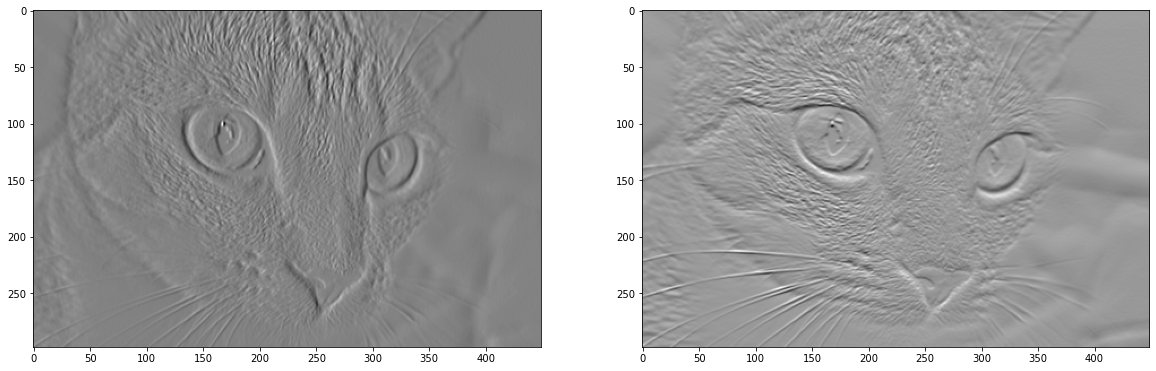

In [ ]:
features = conv(img, l1_filters)
%timeit conv(img,l1_filters)

print('Convolutional feature maps shape:', features.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(features[:,:,0], cmap='gray')
ax2.imshow(features[:,:,1], cmap='gray')
plt.show()

See the time, what is different? :-)

Cool, right? A couple observations:
1. We've hard coded the values in the filters, so they are sensible to us. In a real CNN, we'd be tuning the filters to minimize loss on the training set, so we wouldn't expect such perfectly structured results.
2. Naive implementation of 2D convolutions requires 4 nested loops, which is super slow in Python. In the code above, we've replaced the two inner loops with an element-by-element matrix multiplication for the kernel and the portion of the image applicable for the current indices into the convoution result.

### Exercise (15 points)

The semi-naive implementation of the convolution function above could be sped up with the use of a fast low-level 2D convolution routine that makes the best possible use of the CPU's optimized instructions, pipelining of operations, etc. Take a look at [Laurent Perrinet's blog on 2D convolution implementations](https://laurentperrinet.github.io/sciblog/posts/2017-09-20-the-fastest-2d-convolution-in-the-world.html) and see how the two fastest implementations,
scikit and numpy, outperform other methods and should vastly outperform the Python loop above. Reimplement the <code>convolve()</code> function above to be <code>convole2()</code> and compare
the times taken by the naive and optimized versions of your convolution operation for the cat image. In your report, briefly describe the experiment and the
results you obtained.

- Do faster CNN (10 points)
- Describe the experiment and the results (5 points)

<details>
    <summary><font size="3" color="green"><b>Hint:</b></font></summary>
    
Use <code>numpy.fft</code>

</details>

In [ ]:
from numpy.fft  import fft2, ifft2
def convolve2(img, conv_filter):
    output = None
    # YOUR CODE HERE
    output = np.real(ifft2(fft2(img)*fft2(conv_filter, s=img.shape)))[conv_filter.shape[0]-1:,conv_filter.shape[0]-1:]
    # raise NotImplementedError()
    return output

def conv2(img, conv_filters):
    # Check shape of inputs
    if len(img.shape) != len(conv_filters.shape) - 1: 
        raise Exception("Error: Number of dimensions in conv filter and image do not match.")  

    # Ensure filter depth is equal to number of channels in input
    if len(img.shape) > 2 or len(conv_filters.shape) > 3:
        if img.shape[-1] != conv_filters.shape[-1]:
            raise Exception("Error: Number of channels in both image and filter must match.")
            
    # Ensure filters are square
    if conv_filters.shape[1] != conv_filters.shape[2]: 
        raise Exception('Error: Filter must be square (number of rows and columns must match).')

    # Ensure filter dimensions are odd
    if conv_filters.shape[1]%2==0: 
        raise Exception('Error: Filter must have an odd size (number of rows and columns must be odd).')

    # Prepare output
    feature_maps = np.zeros((img.shape[0]-conv_filters.shape[1]+1, 
                             img.shape[1]-conv_filters.shape[1]+1, 
                             conv_filters.shape[0]))

    # Perform convolutions
    # YOUR CODE HERE
    for num_filter in range(conv_filters.shape[0]):
        
        temp_filter = conv_filters[num_filter, :]
        
        if len(temp_filter.shape) > 2:            
            conv_map = convolve2(img[:, :, 0], temp_filter[:, :, 0])
            for channel in range(1, temp_filter.shape[-1]):
                conv_map = conv_map + convolve2(img[:, :, channel], temp_filter[:, :, channel])
        else:
            conv_map = convolve2(img, temp_filter)
        feature_maps[:, :, num_filter] = conv_map
    
    #raise NotImplementedError()

    return feature_maps

30.2 ms ± 930 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Convolutional feature maps shape: (298, 449, 2)


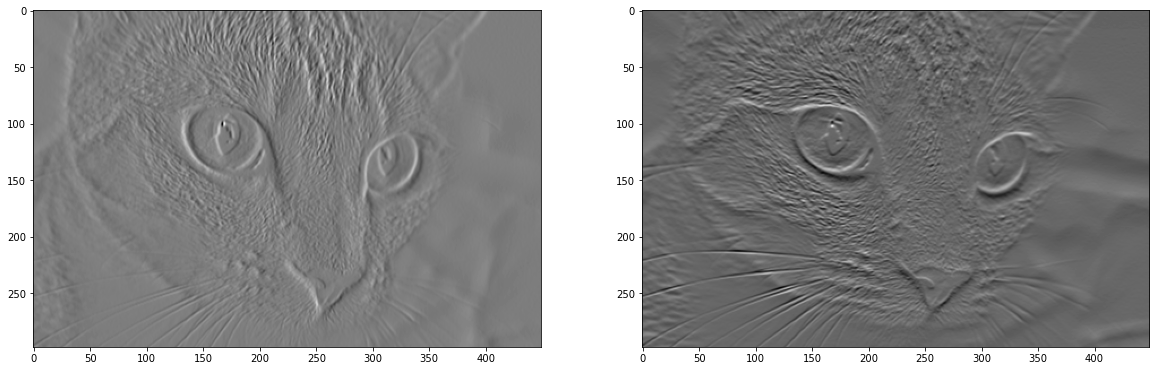

success!


In [ ]:
import datetime
start = datetime.datetime.now()
features = conv2(img, l1_filters)
stop = datetime.datetime.now()
%timeit conv2(img,l1_filters)

c = stop - start
elapsed = c.microseconds / 1000 # millisec

print('Convolutional feature maps shape:', features.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(features[:,:,0], cmap='gray')
ax2.imshow(features[:,:,1], cmap='gray')
plt.show()

# Test function: Do not remove
assert elapsed < 200, "Convolution is too slow, try again"
print("success!")
# End Test function

YOUR ANSWER HERE

From the result images, we can see that the features seem to be swapped from the naive implementation. Moreover, the naive implementation of the convolution function became faster with the use of the low-level 2D convolution routine. It can be observed that, the time required for the naive implementation was around 3-4 seconds, whereas the optimized convolution takes around 30 miliseconds. So, we can conclude that the optimized operation is 100 times faster than the previous one.

### Pooling and relu

Next, consider the feedforward pooling and ReLU operations.

In [ ]:
# Pooling layer with particular size and stride

def pooling(feature_map, size=2, stride=2):
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride+1),
                         np.uint16((feature_map.shape[1]-size+1)/stride+1),
                         feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0,feature_map.shape[0]-size+1, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r+size,  c:c+size, map_num]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

# ReLU activation function

def relu(feature_map):
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0,feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    return relu_out

Now let's try ReLU and pooling:

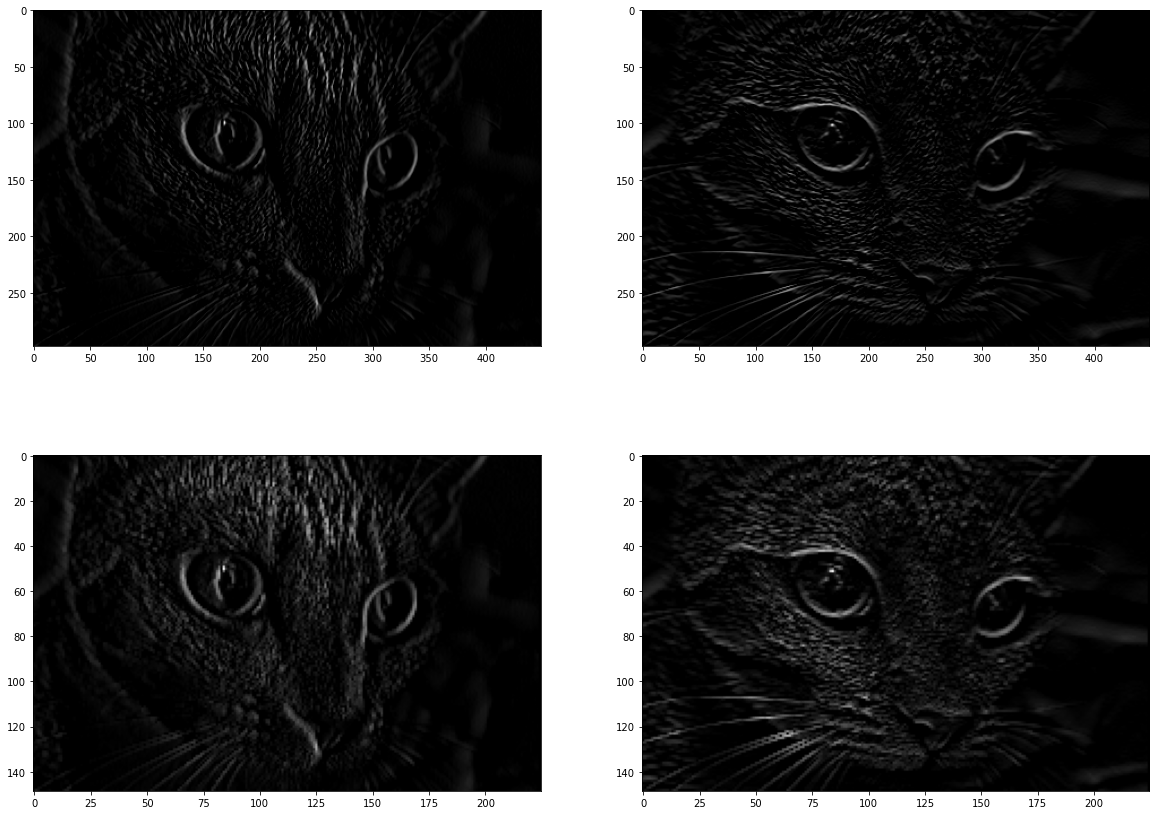

In [ ]:
relued_features = relu(features)
pooled_features = pooling(relued_features)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
ax1.imshow(relued_features[:,:,0], cmap='gray')
ax2.imshow(relued_features[:,:,1], cmap='gray')
ax3.imshow(pooled_features[:,:,0], cmap='gray')
ax4.imshow(pooled_features[:,:,1], cmap='gray')
plt.show()


Let's visualize all of the feature maps in the model...

In [ ]:
# First conv layer

import sys

np.set_printoptions(threshold=sys.maxsize)

print("conv layer 1...")
l1_feature_maps = conv(img, l1_filters)
l1_feature_maps_relu = relu(l1_feature_maps)
l1_feature_maps_relu_pool = pooling(l1_feature_maps_relu, 2, 2)

# Second conv layer

print("conv layer 2...")
l2_filters = np.random.rand(3, 5, 5, l1_feature_maps_relu_pool.shape[-1])
l2_feature_maps = conv(l1_feature_maps_relu_pool, l2_filters)
l2_feature_maps_relu = relu(l2_feature_maps)
l2_feature_maps_relu_pool = pooling(l2_feature_maps_relu, 2, 2)
#print(l2_feature_maps)

# Third conv layer

print("conv layer 3...")
l3_filters = np.random.rand(1, 7, 7, l2_feature_maps_relu_pool.shape[-1])
l3_feature_maps = conv(l2_feature_maps_relu_pool, l3_filters)
l3_feature_maps_relu = relu(l3_feature_maps)
l3_feature_maps_relu_pool = pooling(l3_feature_maps_relu, 2, 2)


conv layer 1...
conv layer 2...
conv layer 3...


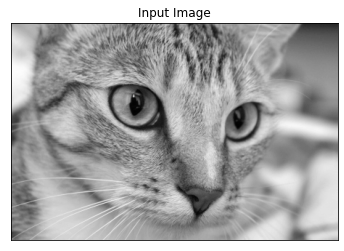

In [ ]:
# Show results

fig0, ax0 = plt.subplots(nrows=1, ncols=1)
ax0.imshow(img).set_cmap("gray")
ax0.set_title("Input Image")
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
plt.show()


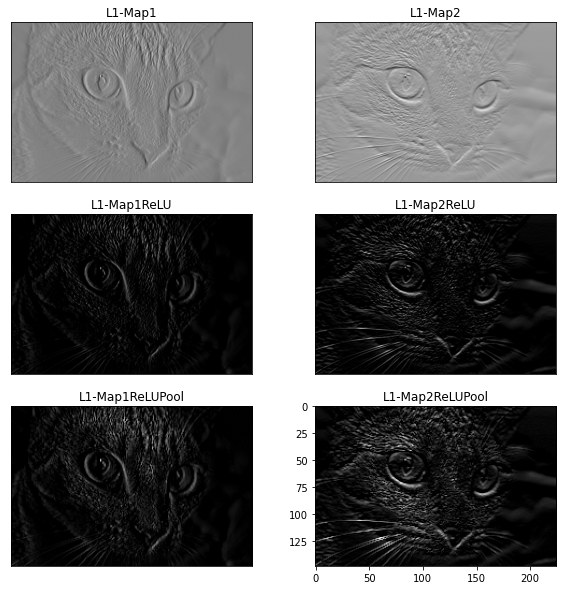

In [ ]:
# Layer 1
fig1, ax1 = plt.subplots(nrows=3, ncols=2)
fig1.set_figheight(10)
fig1.set_figwidth(10)
ax1[0, 0].imshow(l1_feature_maps[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_maps[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")

plt.show()


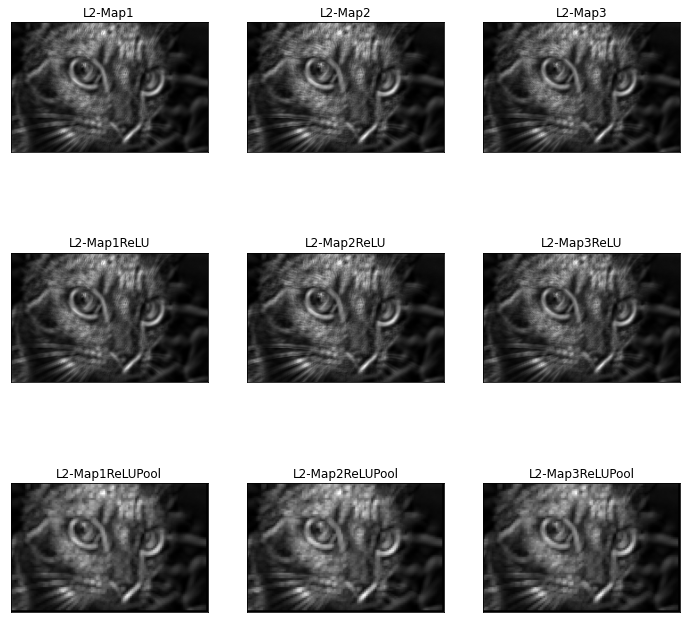

In [ ]:
# Layer 2
fig2, ax2 = plt.subplots(nrows=3, ncols=3)
fig2.set_figheight(12)
fig2.set_figwidth(12)
ax2[0, 0].imshow(l2_feature_maps[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_maps[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_maps[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_maps_relu[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_maps_relu_pool[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")
plt.show()

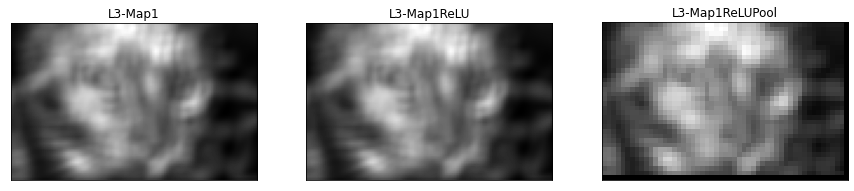

In [ ]:
# Layer 3

fig3, ax3 = plt.subplots(nrows=1, ncols=3)
fig3.set_figheight(15)
fig3.set_figwidth(15)
ax3[0].imshow(l3_feature_maps[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool")
plt.show()

We can see that at progressively higher layers of the network, we get coarser representations of the input. Since the filters at the later layers
are random, they are not very structured, so we get a kind of blurring effect. These visualizations would be more meaningful in model with learned
filters.

### Exercise 2 (15 points)

Modify CNN 3 layer above with your <code>conv2()</code> function. Check the result and explain what you did and what is the different result.

In [ ]:
# YOUR CODE HERE

# First conv layer

import sys
np.set_printoptions(threshold=sys.maxsize)

print("conv2 layer 1...")
l1_feature_maps_2 = conv2(img, l1_filters)
l1_feature_maps_relu_2 = relu(l1_feature_maps_2)
l1_feature_maps_relu_pool_2 = pooling(l1_feature_maps_relu_2, 2, 2)

# Second conv layer

print("conv2 layer 2...")
l2_filters_2 = np.random.rand(3, 5, 5, l1_feature_maps_relu_pool_2.shape[-1])
l2_feature_maps_2 = conv2(l1_feature_maps_relu_pool_2, l2_filters_2)
l2_feature_maps_relu_2 = relu(l2_feature_maps_2)
l2_feature_maps_relu_pool_2 = pooling(l2_feature_maps_relu_2, 2, 2)
#print(l2_feature_maps)

# Third conv layer

print("conv2 layer 3...")
l3_filters_2 = np.random.rand(1, 7, 7, l2_feature_maps_relu_pool_2.shape[-1])
l3_feature_maps_2 = conv2(l2_feature_maps_relu_pool_2, l3_filters_2)
l3_feature_maps_relu_2 = relu(l3_feature_maps_2)
l3_feature_maps_relu_pool_2 = pooling(l3_feature_maps_relu_2, 2, 2)

# raise NotImplementedError()

conv2 layer 1...
conv2 layer 2...
conv2 layer 3...


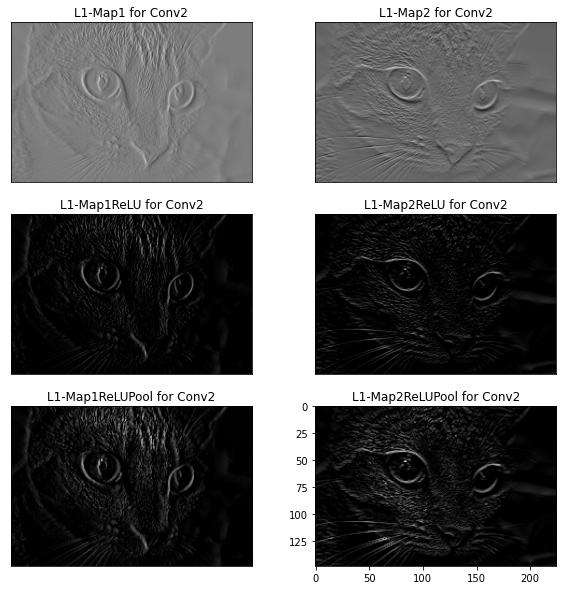

In [ ]:
# Layer 1
fig1, ax1 = plt.subplots(nrows=3, ncols=2)
fig1.set_figheight(10)
fig1.set_figwidth(10)
ax1[0, 0].imshow(l1_feature_maps_2[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1 for Conv2")

ax1[0, 1].imshow(l1_feature_maps_2[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2 for Conv2")

ax1[1, 0].imshow(l1_feature_maps_relu_2[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU for Conv2")

ax1[1, 1].imshow(l1_feature_maps_relu_2[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU for Conv2")

ax1[2, 0].imshow(l1_feature_maps_relu_pool_2[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool for Conv2")

ax1[2, 1].imshow(l1_feature_maps_relu_pool_2[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool for Conv2")

plt.show()

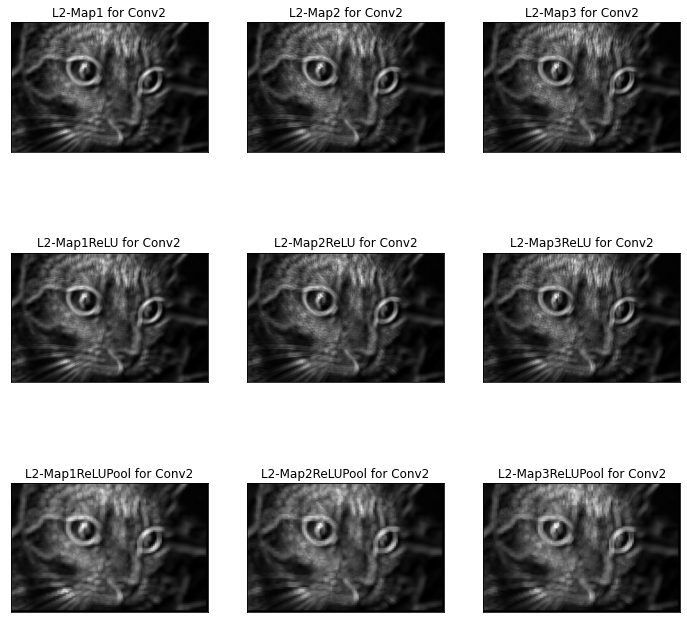

In [ ]:
# Layer 2
fig2, ax2 = plt.subplots(nrows=3, ncols=3)
fig2.set_figheight(12)
fig2.set_figwidth(12)
ax2[0, 0].imshow(l2_feature_maps_2[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1 for Conv2")

ax2[0, 1].imshow(l2_feature_maps_2[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2 for Conv2")

ax2[0, 2].imshow(l2_feature_maps_2[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3 for Conv2")

ax2[1, 0].imshow(l2_feature_maps_relu_2[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU for Conv2")

ax2[1, 1].imshow(l2_feature_maps_relu_2[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU for Conv2")

ax2[1, 2].imshow(l2_feature_maps_relu_2[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU for Conv2")

ax2[2, 0].imshow(l2_feature_maps_relu_pool_2[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool for Conv2")

ax2[2, 1].imshow(l2_feature_maps_relu_pool_2[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool for Conv2")

ax2[2, 2].imshow(l2_feature_maps_relu_pool_2[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool for Conv2")

plt.show()

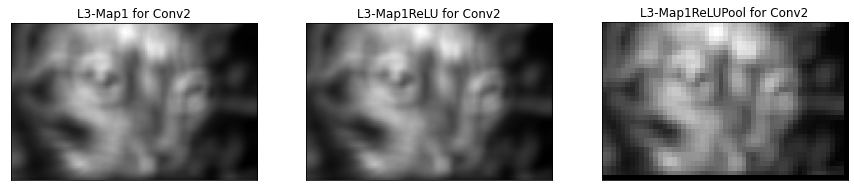

In [ ]:
# Layer 3

fig3, ax3 = plt.subplots(nrows=1, ncols=3)
fig3.set_figheight(15)
fig3.set_figwidth(15)
ax3[0].imshow(l3_feature_maps_2[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1 for Conv2")

ax3[1].imshow(l3_feature_maps_relu_2[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU for Conv2")

ax3[2].imshow(l3_feature_maps_relu_pool_2[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool for Conv2")
plt.show()

YOUR ANSWER HERE

For the 1st layer, we can observe that the features have swapped their positions in the result images from the naive implementation. For the 2nd layer, the result images were almost similar after the convolution, relu and maxpooling operations. For the 3rd layer, the image was blurred after the convolution but it seems that the important features were extracted from the image after the maxpooling operation.

## CNNs in PyTorch

Now we'll do a more complete CNN example using PyTorch. We'll use the MNIST digits again. The example is based on
[Anand Saha's PyTorch tutorial](https://github.com/anandsaha/deep.learning.with.pytorch).

PyTorch has a few useful modules for us:
1. cuda: GPU-based tensor computations
2. nn: Neural network layer implementations and backpropagation via autograd
3. torchvision: datasets, models, and image transformations for computer vision problems.

torchvision itself includes several useful elements:
1. datasets: Datasets are subclasses of torch.utils.data.Dataset. Some of the common datasets available are "MNIST," "COCO," and "CIFAR." In this example we will see how to load MNIST dataset using a custom subclass of the datasets class.
2. transforms - Transforms are used for image transformations. The MNIST dataset from torchvision is in PIL image. 
To convert MNIST images to tensors, we will use `transforms.ToTensor()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
import torch.cuda as cuda
import torch.nn as nn

from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

# The functional module contains helper functions for defining neural network layers as simple functions
import torch.nn.functional as F

### Load the MNIST data

First, let's load the data and transfrom the input elements (pixels) so that their mean over the entire training dataset is 0 and its standard deviation is 1.

In [ ]:
# Desired mean and standard deviation

mean = 0.0
stddev = 1.0

# Transform input image

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean), (stddev))])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_valid = datasets.MNIST('./data', train=False, download=True, transform=transform)

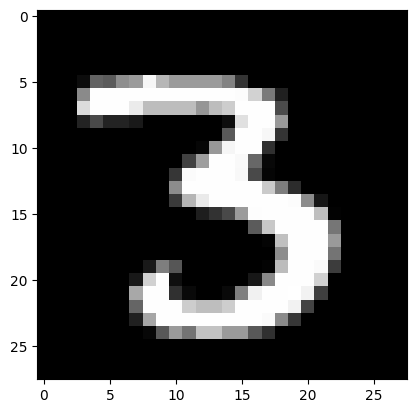

In [ ]:
img = mnist_train[12][0].numpy()
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.show()

Create **loader** that can connect to the dataset which you created

In [ ]:
label = mnist_train[12][1]
print('Label of image above:', label)

# Reduce batch size if you get out-of-memory error

batch_size = 1024
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)

Label of image above: 3


### Define the NN model

We use 2 convolutional layers followed by 2 fully connected layers. The input size of each image is (28,28,1). We will use stide of size 1 and padding of size 0.

For first convolution layer we will apply 20 filters of size (5,5).   CNN output formula $$\text{output size} = \frac{W - F + 2P}{S} + 1$$ where $W$ - input, $F$ - filter size, $P$ - padding size and $S$ - stride size.

We get $\frac{(28,28,1) - (5,5,1) + (2*0)}{1} + 1$ for each filter, so for 10 filters we get output size of (24,24,10).

The ReLU activation function is applied to the output of the first convolutional layer.

For the second convolutional layer, we apply 20 filters of size (5,5), giving us output of size of (20,20,20). Maxpooling with a size of 2 is applied to the output of the second convolutional layer, thereby giving us an output size of of (10,10,20). The ReLU activation function is applied to the output of the maxpooling layer.

Next we have two fully connected layers. The input of the first fully connected layer is flattened output of $10*10*20 = 2000$, with 50 nodes. The second layer is the output layer and has 10 nodes.

### Important words (for PyTorch)

**Tensor** - any matrix arrays which use for calculation, you can call input, output, weight as any tensors. In CNNs, we use "input tensor" as input; i.e. image, and "output tensor" as output.

**Kernel** - filter tensor, or weight tensor. In computer vision, we might call mask tensor or mask matrix.

**Channel** - number of depth in tensor, so sometime we call **depth**.

**Feature** - Specific characteristic information for using in **dense layers** or **fully connect layers**.

**Feature extraction** - the process of transforming raw data into numerical features that can be processed while preserving the information in the original data set.

**Stride** - The jump necessary to go from one element to the next one in the specified dimension dim . A tuple of all strides is returned when no argument is passed in.

**Padding** - the zero array extends in both sides of tensor.


In PyTorch, the function of CNNs is no need to input size, but it needs to fill number of channels and kernel size, including operation in the layer. For dense layer or fully layer, we need to set input features number and output features number. Thus, it is necessary to understand how to calculate tensors and features size in each layer.

### PyTorch model architecture

PyTorch deep learning models come in (at least) two possible styles:

<img src="img/NNinPytorch.png" style="width: 500px;" />

1. The PyTorch Sequential API is very expressive when we have a straightforward sequence of operations to perform on the input.
2. The PyTorch Module allows more flexible transformations of inputs, combination of multiple inputs, generation of multiple outputs, and so on.

### Number of parameters and output tensors size calculation

#### CNN parameters

Kernel size $k$ in 1 layer for 1 channel output can be calculated by

$$k = k_w \times k_h \times i_c$$

when $k_w$ is width of kernel, $k_h$ is width of kernel, and $i_c$ is input channels. We need to have $o_c$ kernels for release $o_c$ output channels. Therefore, for 1 layer of CNN, number of parameters can be calculated as

$$n_p = k \times o_c = (k_w \times k_h \times i_c) \times o_c$$

For bias in CNNs, it usually become all zeros, but we can assign bias CNNs in PyTorch. The **bias size** is equal to the **output tensor size**.

#### Fully connect parameters

Weight size $s_w$ in 1 layers can be calculated by

$$s_w = i_f \times o_f$$

when $i_f$ is input features, and $o_f$ is output features. For bias, the size is equal to **output feature size**.

We can calculate that the total parameters number is the parameters of all layers, so the network size can be used from the parameters number. It is useful to tell how efficient of the network (How fast)

#### output tensors size

If we have an input tensor or image input size $w \times h$ which want to convolution with $k_w \times k_h$ kernel size with padding $p$ and stride $s$, we can calculate output tensor size as:

$$output_{size}=\lfloor \frac{w+2p-k_w}{s} + 1 \rfloor \times \lfloor \frac{h+2p-k_h}{s} + 1 \rfloor $$

For example, input image in the first layer is $224 \times 224$. Using $11 \times 11$ of kernel size with padding $2$ and stride 4. We calculate

$$output_{size}=\lfloor \frac{w+2p-k_w}{s} + 1 \rfloor = \lfloor \frac{224+2(2)-11}{4} + 1 \rfloor = \lfloor 55.25 \rfloor = 55$$

In [ ]:
class CNN_Model(nn.Module):
    
    def __init__(self):
        super().__init__()
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)      # 24 x 24 x 20  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)     # 20 x 20 x 20  (after 2nd convolution)
        #self.conv2_drop = nn.Dropout2d(p=0.5)            # Dropout is a regularization technqiue we discussed in class
        self.maxpool2 = nn.MaxPool2d(2)                   # 10 x 10 x 20  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(2000, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        #x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch from activation maps to vectors
        x = x.view(-1, 2000)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, training=True)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

#### Create the objects

In [ ]:
# The model
net = CNN_Model()

if cuda.is_available():
    net = net.cuda()

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) 

#### Print out the network

In [ ]:
print(net)

CNN_Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): Linear(in_features=2000, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


#### Training loop

In [ ]:
num_epochs = 20

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = net(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / float(len(mnist_train_loader.dataset))))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    net.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(mnist_valid_loader.dataset) * 100.0)

    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/20, Tr Loss: 1.8661, Tr Acc: 38.9733, Val Loss: 0.5822, Val Acc: 82.0800
Epoch 2/20, Tr Loss: 0.4553, Tr Acc: 86.3300, Val Loss: 0.3122, Val Acc: 90.4600
Epoch 3/20, Tr Loss: 0.2853, Tr Acc: 91.4467, Val Loss: 0.2291, Val Acc: 93.0400
Epoch 4/20, Tr Loss: 0.2271, Tr Acc: 93.1017, Val Loss: 0.1862, Val Acc: 94.2700
Epoch 5/20, Tr Loss: 0.1797, Tr Acc: 94.5833, Val Loss: 0.1649, Val Acc: 94.9100
Epoch 6/20, Tr Loss: 0.1508, Tr Acc: 95.4550, Val Loss: 0.1370, Val Acc: 95.8900
Epoch 7/20, Tr Loss: 0.1287, Tr Acc: 96.1883, Val Loss: 0.1085, Val Acc: 96.6900
Epoch 8/20, Tr Loss: 0.1117, Tr Acc: 96.6283, Val Loss: 0.0981, Val Acc: 96.9400
Epoch 9/20, Tr Loss: 0.1014, Tr Acc: 96.9617, Val Loss: 0.0911, Val Acc: 97.3000
Epoch 10/20, Tr Loss: 0.0927, Tr Acc: 97.2133, Val Loss: 0.0856, Val Acc: 97.3300
Epoch 11/20, Tr Loss: 0.0860, Tr Acc: 97.4033, Val Loss: 0.0798, Val Acc: 97.6300
Epoch 12/20, Tr Loss: 0.0797, Tr Acc: 97.5867, Val Loss: 0.0779, Val Acc: 97.6800
Epoch 13/20, Tr Loss: 0.0

We can see that the model is still learning something. We might want to train another 10 epochs or so to see if validation accuracy increases further. For now, though, we'll just save the model.

In [ ]:
# save the model
torch.save(net.state_dict(), "./3.model.pth")

Next, let's visualize the loss and accuracy

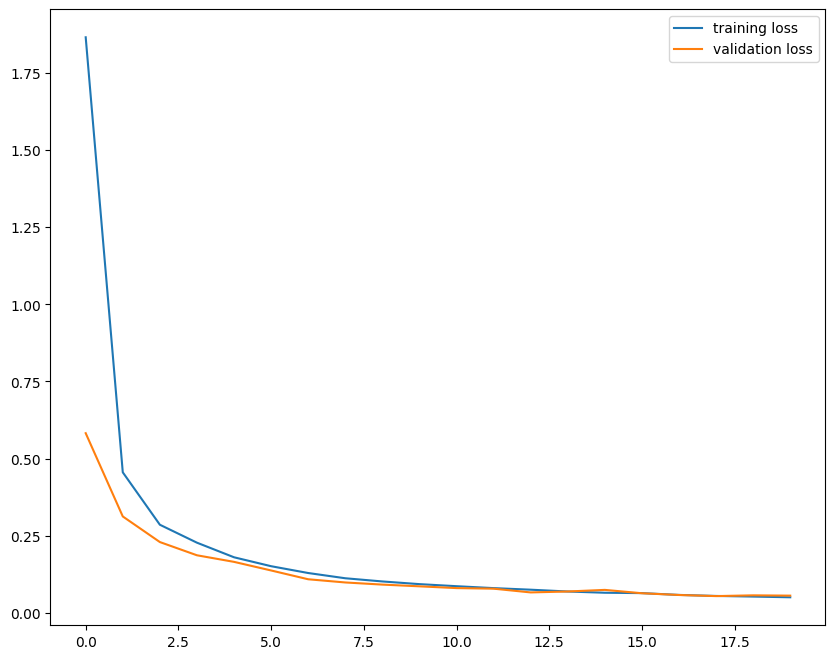

In [ ]:
# Plot loss curves

f = plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

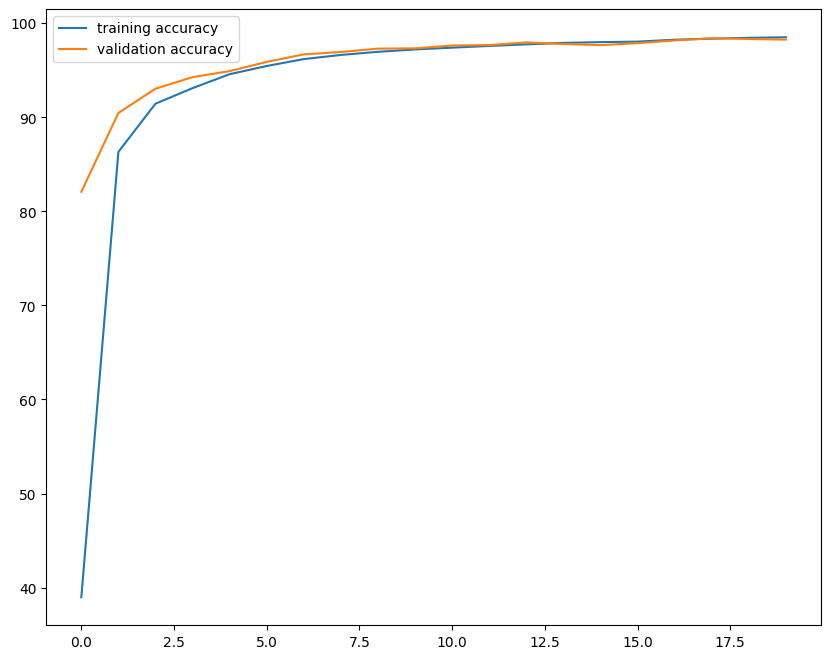

In [ ]:
# Plot accuracy curves

f = plt.figure(figsize=(10, 8))
plt.plot(train_accuracy, label='training accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.legend()
plt.show()

What can you conclude from the loss and accuracy curves?
1. We are not overfitting (at least not yet)
2. We should continue training, as validation loss is still improving
3. Validation accuracy is much higher than last week's fully connected models

Now let's test on a single image.

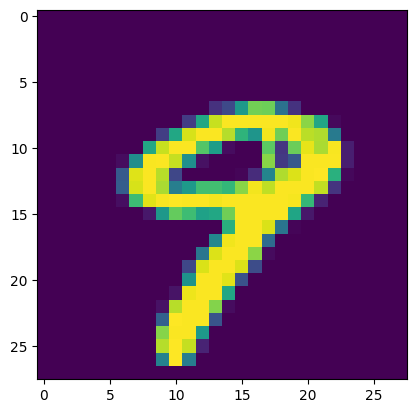

In [ ]:
image_index = 9
img = mnist_valid[image_index][0].resize_((1, 1, 28, 28))
img = Variable(img)
label = mnist_valid[image_index][1]
plt.imshow(img[0,0])
net.eval()

if cuda.is_available():
    net = net.cuda()
    img = img.cuda()
else:
    net = net.cpu()
    img = img.cpu()
    
output = net(img)

In [ ]:
output

tensor([[ -4.4674, -11.1107,  -5.2382,  -2.5742,   4.1545,  -4.9005,  -8.5732,
           5.4943,   0.4973,   9.1131]], grad_fn=<AddmmBackward0>)

In [ ]:
_, predicted = torch.max(output.data, 1)
print("Predicted label:", predicted[0].item())
print("Actual label:", label)

Predicted label: 9
Actual label: 9


### Take-home exercise (70 points)

Apply the tech you've learned up till now to take Kaggle's 2013 [Dogs vs. Cats Challenge](https://www.kaggle.com/c/dogs-vs-cats). Download the training and test datasets and try to build the best PyTorch CNN you can for this dataset. Describe your efforts and the results in a brief lab report.

In [3]:
import numpy as np
import pandas as pd
import random

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [5]:
import torch
import torch.cuda as cuda
import torch.nn as nn

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torchvision
from torchvision import datasets
from torchvision import transforms

# The functional module contains helper functions for defining neural network layers as simple functions
import torch.nn.functional as F

In [6]:
import zipfile

zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("/content/gdrive/MyDrive/lab09/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [7]:
train_path = '/content/gdrive/MyDrive/lab09/train.zip'
test_path = '/content/gdrive/MyDrive/lab09/test1.zip'

extracted_train = '/content/gdrive/MyDrive/lab09/extracted'
extracted_test = '/content/gdrive/MyDrive/lab09/extracted'

with zipfile.ZipFile(train_path, 'r') as train_zip_ref:
    train_zip_ref.extractall(extracted_train)
    
with zipfile.ZipFile(test_path, 'r') as test_zip_ref:
    test_zip_ref.extractall(extracted_test)

In [8]:
img_files = os.listdir('./train')
img_files = list(filter(lambda x: x != 'train', img_files))

In [9]:
def train_path(p): 
  return f"./train/{p}"

img_files = list(map(train_path, img_files))

In [10]:
# Checking total Images in training data

print("Total number of training images:", len(img_files))

Total number of training images: 25000


In [11]:
from sklearn.model_selection import train_test_split

# create train-validation split
random.shuffle(img_files)

from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(img_files , test_size =0.2)

print("Train size:", len(train_set))
print("Test size:", len(val_set))

Train size: 20000
Test size: 5000


In [12]:
# image normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [13]:
from PIL import Image

# preprocessing of images
class CatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        # self.train_dir = train_dir
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __getitem__(self, index): 

        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)

        # image_path = self.images[index]
        # label = self.images[index].split(".")[0]

        # label = 0 if label == 'cat' else 1
        # img = cv2.imread(image_path)
        # if self.transform:
        #     img = self.transform(img)
        # img = img.numpy()
        # return img.astype('float32'), label

    def __len__(self): 
      return self.len

In [14]:
# creating train dataset
train_dataset = CatDogDataset(train_set, transform)
train_dataloader = DataLoader(train_dataset, batch_size=100)
print(len(train_dataset), len(train_dataloader))

# creating validation dataset
val_dataset = CatDogDataset(val_set, transform)
val_dataloader = DataLoader(val_dataset, batch_size=100)
print(len(val_dataset), len(val_dataloader))

20000 200
5000 50


In [15]:
# creating Convolutional Neural Network architecture
class CatAndDogConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)

        self.fc1 = nn.Linear(in_features= 64 * 6 * 6, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=2)


    def forward(self, X):

        X = F.max_pool2d(F.relu(self.conv1(X)), 2)
        X = F.max_pool2d(F.relu(self.conv2(X)), 2)
        X = F.max_pool2d(F.relu(self.conv3(X)), 2)

        X = X.view(X.shape[0], -1)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return X

In [17]:
# creating instance of the model
model = CatAndDogConvNet()

losses = []
accuracies = []
epoches = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# training model
for epoch in range(epoches):

    epoch_loss = 0
    epoch_accuracy = 0

    for X, y in train_dataloader:

        preds = model(X)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)

    epoch_accuracy = epoch_accuracy/len(train_dataloader)
    accuracies.append(epoch_accuracy)

    epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(epoch_loss)

    print("\nEpoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}".format(epoch+1, epoch_loss, epoch_accuracy))

    # validation set accuracy 
    with torch.no_grad():

        val_epoch_loss = 0
        val_epoch_accuracy = 0

        for val_X, val_y in val_dataloader:

            val_preds = model(val_X)
            val_loss = loss_fn(val_preds, val_y)

            val_epoch_loss += val_loss            
            val_accuracy = ((val_preds.argmax(dim=1) == val_y).float().mean())
            val_epoch_accuracy += val_accuracy

        val_epoch_accuracy = val_epoch_accuracy/len(val_dataloader)
        val_epoch_loss = val_epoch_loss / len(val_dataloader)

        print("Epoch: {}, Validation loss: {:.4f}, Validation accuracy: {:.4f}\n".format(epoch+1, val_epoch_loss, val_epoch_accuracy))

........................................................................................................................................................................................................
Epoch: 1, Train loss: 0.6397, Train accuracy: 0.6182
Epoch: 1, Validation loss: 0.5633, Validation accuracy: 0.7088

........................................................................................................................................................................................................
Epoch: 2, Train loss: 0.5161, Train accuracy: 0.7391
Epoch: 2, Validation loss: 0.4887, Validation accuracy: 0.7638

........................................................................................................................................................................................................
Epoch: 3, Train loss: 0.4558, Train accuracy: 0.7819
Epoch: 3, Validation loss: 0.4533, Validation accuracy: 0.7884

..............................................

In [18]:
test_imgs = os.listdir('./test1/')
test_files = list(filter(lambda x: x != 'test1', test_imgs))

In [19]:
def test_path(p): 
  return f"./test1/{p}"

test_files = list(map(test_path, test_files))

In [20]:
class TestCatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        fileid = path.split('/')[-1].split('.')[0]
        return (image, fileid)

    def __len__(self): 
      return self.len

In [23]:
# creating test dataset
test_dataset = TestCatDogDataset(test_files, transform)
test_dataloader = DataLoader(test_dataset, batch_size=100)
print(len(test_dataset), len(test_dataloader))

12500 125


In [24]:
dog_probs = []

with torch.no_grad():
    for X, fileid in test_dataloader:
        preds = model(X)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip((fileid), preds_list))

In [25]:
dog_probs.sort(key = lambda x: int(x[0]))

In [26]:
dog_probs[:5]

[('1', 0.9299675822257996),
 ('2', 0.9975712895393372),
 ('3', 0.344850093126297),
 ('4', 0.9987590312957764),
 ('5', 0.2524445652961731)]

In [27]:
idx = list(map(lambda x :x[0], dog_probs))
prob = list(map(lambda x :x[1], dog_probs))

In [28]:
test_df = pd.DataFrame({'id':idx, 'label':prob})

In [29]:
test_df

id     label
0          1  0.929968
1          2  0.997571
2          3  0.344850
3          4  0.998759
4          5  0.252445
...      ...       ...
12495  12496  0.005462
12496  12497  0.043184
12497  12498  0.870450
12498  12499  0.873400
12499  12500  0.015674

[12500 rows x 2 columns]

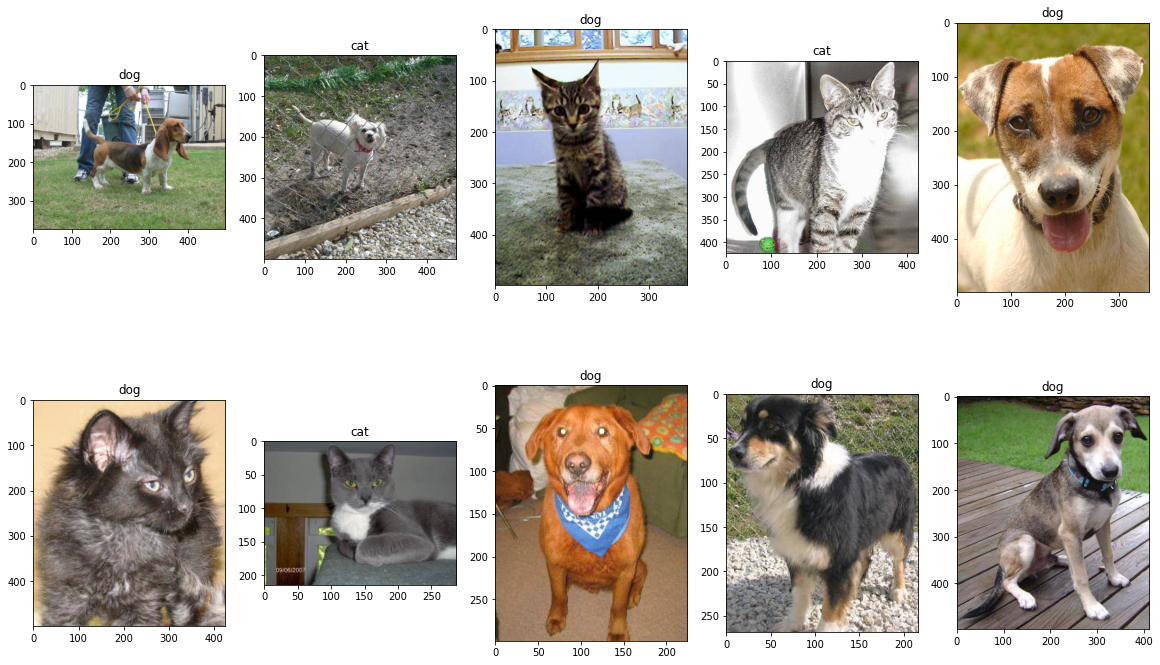

In [38]:
id_list = []
class_list = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(test_df['id'].values)
    
    label = test_df.loc[test_df['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join('/content/gdrive/MyDrive/lab09/extracted/test1', '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_list[label])
    ax.imshow(img)

## Report

In lab exercise, we implemented handcoded CNN with a convolutional layer, a ReLU activation layer and max pooling layer. The implementation requires time between 3 and 4 seconds. Then we used a low-level 2D convolution routine for the same task, where the the operation took around 30 miliseconds. The optimized operation was 100 times faster than the naive implementation. From the output images, it can be noticed that the features were swapped in the optimized operation from the naive one. 

Then we implemented feedforward pooling and ReLU operations. For the 1st layer, the features have swapped their positions in the output images while we used optimized convolution operation. The output images were almost similar after the convolution, relu and maxpooling operations for the 2nd layer. The image was blurred after the convolution but it became coarser after maxpooling operation in the 3rd layer. These visualizations would be more meaningful in model with learned filters.

We also implemented CNN in MNIST digit dataset in Pytorch. The CNN model has 1st convolution layer followed by a ReLU activation layer, 2nd convolution layer followed by a maxpool layer and a ReLU activation layer and two fully-connected layer. We used 20 epochs to train the model with a learning rate of 0.01. Then we plotted the training, validation loss curves and also training, validation accuracy curves. Finally, we tested on a single image where we got the right predicted label as the actual label.

For take-home exercise, we used "Dogs vs. Cats Challenge" dataset from Kaggle. We created train and validation dataset from the train folder and did the required preprocessing of the images. We labelled the images from the image file, where label 0 indicates an image of cat and label 1 indicates an image of dog. Then we created the CNN architecture for our model, where we used 3 convolution layers, each followed by a ReLU activation layer and a maxpooling layer. We used 2 fully-connected layers, each followed by a ReLU activation layer and finally a fully-connected layer as the output layer. After creating the model, we trained the model with 5 epochs. Then we created the test dataset from the test1 folder, where the images were not labelled. We could obtain the probability for each image, where the probability less than 0.5 indicates a cat and the probability greater than 0.5 indicates a dog. We tested the model on some images from the test dataset where most of the predictions were right. 
